##  Extract the Astronomical Object from Images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

def align_images_multiple_references(reference_image_paths, distorted_image_path):
    # Load the distorted image
    dist_img = cv2.imread(distorted_image_path)
    dist_gray = cv2.cvtColor(dist_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT
    sift = cv2.SIFT_create()

    # Aggregate keypoints and descriptors from all reference images
    ref_keypoints = []
    ref_descriptors = []
    for ref_path in reference_image_paths:
        ref_img = cv2.imread(ref_path)
        ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(ref_gray, None)
        ref_keypoints.extend(keypoints)
        if descriptors is not None:
            if len(ref_descriptors) == 0:
                ref_descriptors = descriptors
            else:
                ref_descriptors = np.vstack((ref_descriptors, descriptors))

    # Detect keypoints and descriptors in the distorted image
    keypoints_dist, descriptors_dist = sift.detectAndCompute(dist_gray, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(ref_descriptors, descriptors_dist)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched keypoints
    ref_pts = np.float32([ref_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dist_pts = np.float32([keypoints_dist[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Estimate homography
    matrix, mask = cv2.findHomography(dist_pts, ref_pts, cv2.RANSAC, 5.0)

    # Warp the distorted image
    h, w = dist_img.shape[:2]
    aligned_image = cv2.warpPerspective(dist_img, matrix, (w, h))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Distorted Image")
    plt.imshow(cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Aligned Image")
    plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return matrix

def transform_image_with_homography(image_path, homography_matrix):
    # Load the image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]  # Get the size from the image itself

    # Apply the homography transformation
    transformed_image = cv2.warpPerspective(image, homography_matrix, (w, h))

    return transformed_image

def reverse_transform_image_with_homography(transformed_image, homography_matrix):
    """
    Reverse the homography transformation on an image.

    Parameters:
        transformed_image: The image that was transformed.
        homography_matrix: The homography matrix used for the forward transformation.

    Returns:
        The reversed (original) image.
    """
    # Calculate the inverse of the homography matrix
    inverse_homography_matrix = np.linalg.inv(homography_matrix)
    
    # Get the size of the transformed image
    h, w = transformed_image.shape[:2]
    
    # Apply the inverse homography transformation
    original_image = cv2.warpPerspective(transformed_image, inverse_homography_matrix, (w, h))
    
    return original_image

def save_homography_matrix(matrix, file_path):
    # Convert the NumPy array to a list for JSON serialization
    matrix_list = matrix.tolist()
    with open(file_path, 'w') as f:
        json.dump(matrix_list, f)

def process_dataset_images(dataset_folder):
    images_folder = os.path.join(dataset_folder, "images")
    
    for image_name in os.listdir(images_folder):
        print(image_name)
        image_path = os.path.join(images_folder, image_name)

        reference_image_paths = [
            './Dataset 2/images/000003.png', './Dataset 2/images/000010.png', './Dataset 2/images/000016.png', './Dataset 2/images/000021.png', './Dataset 2/images/000022.png', './Dataset 2/images/000028.png', './Dataset 2/images/000030.png', './Dataset 2/images/000033.png', './Dataset 2/images/000046.png', './Dataset 2/images/000051.png', './Dataset 2/images/000053.png', './Dataset 2/images/000060.png', './Dataset 2/images/000061.png', './Dataset 2/images/000064.png',
            './Dataset 2/images/000072.png', './Dataset 2/images/000081.png', './Dataset 2/images/000096.png', 
        ]  # Add more references
        #distorted_image_path = './Dataset 2/images/000083.png'
        homography_matrix = align_images_multiple_references(reference_image_paths, image_path)

        # Transform the image
        transformed_image = transform_image_with_homography(image_path, homography_matrix)

        if not cv2.imwrite(f"./calibrated-images/{image_name}", transformed_image):
            print(f"Failed to save image: {image_name}")

        save_homography_matrix(homography_matrix, f"./calibrated-images/{image_name.replace('png', 'json')}")

        # Plot the original and transformed images
        #original_image = cv2.imread(image_path)
        #plt.figure(figsize=(12, 6))
        #plt.subplot(1, 2, 1)
        #plt.title("Original Image")
        #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        #plt.axis("off")

        #plt.subplot(1, 2, 2)
        #plt.title("Transformed Image")
        #plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
        #plt.axis("off")

        #plt.tight_layout()
        #plt.show()

# Example usage
dataset_folder = './Dataset 2'  # Replace with the actual dataset folder
process_dataset_images(dataset_folder)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import json

def load_homography_matrix(file_path):
    # Load the JSON file and convert the list back to a NumPy array
    with open(file_path, 'r') as f:
        matrix_list = json.load(f)
    return np.array(matrix_list)

def reverse_transform_image_with_homography(transformed_image, homography_matrix):
    """
    Reverse the homography transformation on an image.

    Parameters:
        transformed_image: The image that was transformed.
        homography_matrix: The homography matrix used for the forward transformation.

    Returns:
        The reversed (original) image.
    """
    # Calculate the inverse of the homography matrix
    inverse_homography_matrix = np.linalg.inv(homography_matrix)
    
    # Get the size of the transformed image
    h, w = transformed_image.shape[:2]
    
    # Apply the inverse homography transformation
    original_image = cv2.warpPerspective(transformed_image, inverse_homography_matrix, (w, h))
    
    return original_image

def color_thresholding(image, lower_bounds, upper_bounds):
    """
    Perform color thresholding to segment the globe.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        lower_bounds (list of numpy.ndarray): List of lower HSV color bounds.
        upper_bounds (list of numpy.ndarray): List of upper HSV color bounds.

    Returns:
        numpy.ndarray: Binary mask highlighting the selected colors.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    # Apply each color threshold and combine the masks
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect a single circular shape in the image using a color mask to focus the detection.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        color_mask (numpy.ndarray): Binary mask obtained from color thresholding.

    Returns:
        numpy.ndarray: Binary mask with the detected circle.
    """
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    # Convert to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(blurred_image, cmap='gray')
    plt.title(f"Thresholding Result {i:06d}")
    plt.axis("off")
    plt.show()
    # Detect circles using HoughCircles with adjusted parameters
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )

    # Create a binary mask with the same dimensions as the input image
    mask = np.zeros_like(gray_image)
    if circles is not None:
        # Get the first (most prominent) circle
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask

def compute_roc_curve(predicted_mask, ground_truth_mask):
    """
    Compute ROC curve and AUC for a predicted mask and ground truth mask.

    Parameters:
        predicted_mask (numpy.ndarray): Predicted binary mask.
        ground_truth_mask (numpy.ndarray): Ground truth binary mask.

    Returns:
        tuple: (fpr, tpr, roc_auc) False Positive Rate, True Positive Rate, and Area Under Curve.
    """
    # Binarize the masks
    predicted_binary = (predicted_mask > 0).astype(np.uint8).flatten()
    ground_truth_binary = (ground_truth_mask > 0).astype(np.uint8).flatten()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_binary, predicted_binary)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# Dataset paths
images_folder = './Dataset 2/images/'
corrected_images_folder = './calibrated-images/'
masks_folder = './Dataset 2/masks/'

# Bounds for color thresholding
lower_bounds = [
    np.array([100, 50, 50]),  # Lower bound of blue in HSV
    np.array([0, 0, 200]),    # Lower bound of white in HSV
]
upper_bounds = [
    np.array([140, 255, 255]),  # Upper bound of blue in HSV
    np.array([180, 50, 255]),   # Upper bound of white in HSV
]

# Lists to store ROC values
all_fpr = []
all_tpr = []
all_auc = []

# Loop through all images and masks
for i in range(100):
    image_path = os.path.join(images_folder, f"{i:06d}.png")
    corrected_image_path = os.path.join(corrected_images_folder, f"{i:06d}.png")
    mask_path = os.path.join(masks_folder, f"{i:06d}.png")

    # Read image and ground truth mask
    image = cv2.imread(image_path)
    corrected_image = cv2.imread(corrected_image_path)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    loaded_matrix = load_homography_matrix(corrected_image_path.replace("png", "json"))

    # Generate color mask
    color_mask = color_thresholding(corrected_image, lower_bounds, upper_bounds)

    # Plot the thresholding result
    plt.figure(figsize=(6, 6))
    plt.imshow(color_mask, cmap='gray')
    plt.title(f"Thresholding Result {i:06d}")
    plt.axis("off")
    plt.show()

    # Refine circle detection with color mask
    predicted_mask = reverse_transform_image_with_homography(refined_circle_detection_with_mask(image, color_mask), loaded_matrix)

    if not cv2.imwrite(f"./calibrated-images/{i:06d}_predicted_mask.png", predicted_mask):
            print(f"Failed to save {i:06d}_predicted_mask.png")

    # Compute ROC curve
    fpr, tpr, roc_auc = compute_roc_curve(predicted_mask, ground_truth_mask)

    # Store the results
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    # Plot image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i:06d}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Compute average ROC curve (mean TPR for each FPR)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(all_fpr, all_tpr):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr /= len(all_tpr)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot average ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})")
plt.title("Average ROC Curve for Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Print mean AUC
print(f"Mean AUC: {mean_auc:.2f}")


# Task 2

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Dataset paths
images_folder = './Dataset 2/images/'
masks_folder = './calibrated-images/'

def find_mask_center(mask):
    # Compute the coordinates of the white pixels
    white_pixels = np.column_stack(np.where(mask == 255))

    if len(white_pixels) == 0:
        print(f"No white pixels found in mask for index {i}, skipping.")
        return None, None

    # Compute the mean (center location) of the white pixels
    center_y, center_x = white_pixels.mean(axis=0)
    return center_x, center_y

for i in range(100):
    image_path = os.path.join(images_folder, f"{i:06d}.png")
    mask_path = os.path.join(masks_folder, f"{i:06d}_predicted_mask.png")

    # Read image and predicted mask
    image = cv2.imread(image_path)
    predicted_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None or predicted_mask is None:
        print(f"Missing image or mask for index {i}, skipping.")
        continue

    center_x, center_y = find_mask_center(predicted_mask)

    # Plot image and predicted mask
    plt.figure(figsize=(8, 4))

    # Plot the original image with the center marked
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.scatter([center_x], [center_y], color='red', s=40, label='Center')
    plt.title("Original Image with Center")
    plt.legend()
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import cv2
import os

# Define input video path and output folder
video_path = './video.mp4'
output_folder = './video-frames/'
max_images = 100  # Maximum number of frames to save

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open the video file
video_capture = cv2.VideoCapture(video_path)

# Check if video was successfully opened
if not video_capture.isOpened():
    print("Error: Could not open video.")
    exit()

# Get total number of frames in the video
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the interval to capture frames
interval = max(1, total_frames // max_images)

print(f"Total frames: {total_frames}, Saving every {interval}th frame.")

# Read and save frames
frame_count = 0
saved_count = 0

while video_capture.isOpened():
    ret, frame = video_capture.read()
    
    if not ret:
        break  # Break the loop if no more frames are available

    # Save the frame only if it's at the correct interval
    if frame_count % interval == 0:
        output_path = os.path.join(output_folder, f"frame_{saved_count:06d}.png")
        cv2.imwrite(output_path, frame)
        saved_count += 1

        # Stop if we've saved the maximum number of frames
        if saved_count >= max_images:
            break
    
    frame_count += 1

# Release the video capture object
video_capture.release()
print(f"Saved {saved_count} frames to {output_folder}.")


In [ ]:
def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect a single circular shape in the image using a color mask to focus the detection.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        color_mask (numpy.ndarray): Binary mask obtained from color thresholding.

    Returns:
        numpy.ndarray: Binary mask with the detected circle.
    """
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    # Convert to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(blurred_image, cmap='gray')
    plt.title(f"Thresholding Result {i:06d}")
    plt.axis("off")
    plt.show()
    # Detect circles using HoughCircles with adjusted parameters
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )

    # Create a binary mask with the same dimensions as the input image
    mask = np.zeros_like(gray_image)
    if circles is not None:
        # Get the first (most prominent) circle
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask

# Load all frames and process
frame_files = sorted([f for f in os.listdir(output_folder) if f.endswith('.png')])
all_centers = []
first_frame = None

for idx, frame_file in enumerate(frame_files):
    # Read the frame
    frame_path = os.path.join(output_folder, frame_file)
    frame = cv2.imread(frame_path)
    
    if frame is None:
        continue

    if idx == 0:
        first_frame = frame.copy()

    # Apply color thresholding
    binary_mask = color_thresholding(frame, lower_bounds, upper_bounds)

    # Apply refined circle detection (not used for plotting here, but available)
    predicted_mask = refined_circle_detection_with_mask(frame, binary_mask)

    # Find the center of the binary mask
    center = find_mask_center(predicted_mask)
    print(center)
    if center:
        all_centers.append(center)

if first_frame is not None:
    # Convert centers to integer coordinates
    int_centers = [tuple(map(int, center)) for center in all_centers]

    # Find the most left and most right centers
    most_left = min(int_centers, key=lambda point: point[0])  # Minimum x-coordinate
    most_right = max(int_centers, key=lambda point: point[0])  # Maximum x-coordinate

    # Draw a red line between the most left and most right points
    cv2.line(first_frame, most_left, most_right, (0, 0, 255), 2)  # Red line

    # Show the result
    plt.figure(figsize=(10, 6))
    plt.title("Swing Motion Indicator (Left to Right)")
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
# Not-real time processing

import cv2
import numpy as np

# Path to the video
video_path = "video.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")

x, y, w, h = [599, 180, 489, 449]
if w == 0 or h == 0:
    raise ValueError("No valid ROI selected.")

# Extract ROI and detect features in the first frame
first_roi = first_frame[y:y+h, x:x+w]
gray_first_roi = cv2.cvtColor(first_roi, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_first_roi, None)

# Prepare for reverse frame processing
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
best_match_frame = None
max_weighted_score = 0
max_matches = 0

# Process frames in reverse
for i in range(frame_count - 1, -1, -10):
    if i < 0:
        break

    print(f"Processing frame {i}/{frame_count}")
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    if not ret:
        continue
    
    # Extract ROI from the current frame
    roi_frame = frame[y:y+h, x:x+w]
    gray_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)
    
    # Detect features in the current frame
    kp2, des2 = sift.detectAndCompute(gray_roi_frame, None)
    if des2 is None:
        continue

    # Match features using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    
    # Compute weighted score
    weight = i / frame_count  # Higher weight for later frames
    weighted_score = len(good_matches) * weight
    
    # Track the best match
    if weighted_score > max_weighted_score:
        max_weighted_score = weighted_score
        best_match_frame = i
        print(f"New best match at frame {best_match_frame} with {len(good_matches)} matches.")

# Calculate the rotation time
if best_match_frame is not None:
    rotation_time = best_match_frame / frame_rate
    print(f"Full rotation detected at frame {best_match_frame}. Rotation time: {rotation_time:.2f} seconds")
else:
    print("No full rotation detected.")

# Release the video
cap.release()


In [1]:
import cv2

input_path = "video.mp4"
output_path = "multiple_rotations.mp4"

cap = cv2.VideoCapture(input_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Duration to extract: 5 minutes 26 seconds = 5*60 + 26 = 326 seconds
extract_duration = 5*60 + 26  # 326 seconds
frames_to_extract = int(fps * extract_duration)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Read the specified duration from the original video
extracted_frames = []
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        # If video ends before 5:26, break
        break
    extracted_frames.append(frame)
    frame_count += 1
    if frame_count >= frames_to_extract:
        break

# Now, cap might still have frames if video is longer. Close and reopen for full video
cap.release()

# Write first extracted portion (5:26) to the output
for f in extracted_frames:
    out.write(f)

# Reopen original video to write full video again
cap = cv2.VideoCapture(input_path)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)

cap.release()
out.release()

print("Created video_doubled.mp4 with first 5:26 + full video appended.")


Created video_doubled.mp4 with first 5:26 + full video appended.


Frame rate: 29.995203836930454 fps
Frame 10: 952 good matches, elapsed: 0.072s
Frame 20: 884 good matches, elapsed: 0.069s
Frame 30: 759 good matches, elapsed: 0.069s
Frame 40: 797 good matches, elapsed: 0.069s
Frame 50: 788 good matches, elapsed: 0.072s
Frame 60: 747 good matches, elapsed: 0.085s
Frame 70: 787 good matches, elapsed: 0.065s
Frame 80: 743 good matches, elapsed: 0.062s
Frame 90: 698 good matches, elapsed: 0.061s
Frame 100: 738 good matches, elapsed: 0.068s
Frame 110: 736 good matches, elapsed: 0.065s
Frame 120: 704 good matches, elapsed: 0.065s
Frame 130: 731 good matches, elapsed: 0.069s
Frame 140: 695 good matches, elapsed: 0.066s
Frame 150: 666 good matches, elapsed: 0.062s
Frame 160: 720 good matches, elapsed: 0.064s
Frame 170: 706 good matches, elapsed: 0.063s
Frame 180: 621 good matches, elapsed: 0.061s
Frame 190: 644 good matches, elapsed: 0.066s
Frame 200: 650 good matches, elapsed: 0.065s
Frame 210: 622 good matches, elapsed: 0.063s
Frame 220: 665 good matches, 

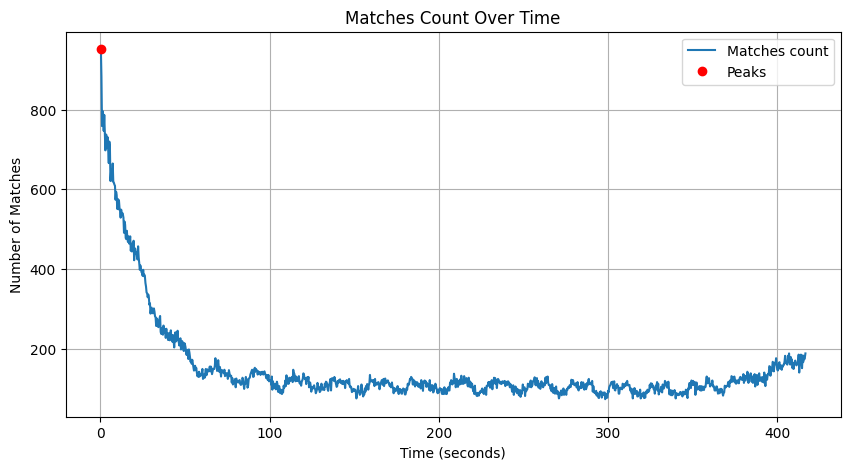

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from scipy.signal import find_peaks

# Path to the video (simulate real-time video)
video_path = "video2.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print(f"Frame rate: {frame_rate} fps")
frame_interval = 10  # Process every 10th frame

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")

# Define ROI (manually set or use a selection tool beforehand)
# x, y, w, h = [599, 180, 489, 449]  # Example ROI
x, y, w, h = [38, 112, 410, 375]  # Example ROI
if w == 0 or h == 0:
    raise ValueError("No valid ROI selected.")

# Extract ROI and detect features in the first frame
first_roi = first_frame[y:y+h, x:x+w]
gray_first_roi = cv2.cvtColor(first_roi, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_first_roi, None)

frame_idx = 0

# Store good matches count for each processed frame
matches_counts = []
processed_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video stream

    frame_idx += 1

    # Skip frames to process every 10th frame
    if frame_idx % frame_interval != 0:
        continue

    start = time.perf_counter()

    # Extract ROI from the current frame
    roi_frame = frame[y:y+h, x:x+w]
    gray_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

    # Detect features in the current frame
    kp2, des2 = sift.detectAndCompute(gray_roi_frame, None)
    if des2 is None:
        matches_counts.append(0)
        processed_frames.append(frame_idx)
        continue

    # Match features using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Record the number of good matches
    matches_counts.append(len(good_matches))
    processed_frames.append(frame_idx)

    end = time.perf_counter()
    elapsed = end - start

    print(f"Frame {frame_idx}: {len(good_matches)} good matches, elapsed: {elapsed:.3f}s")

cap.release()

# Convert frame indices to time
processed_times = np.array(processed_frames) / frame_rate

# Find peaks in the matches_counts array
# Adjust parameters as needed (e.g., prominence, height) to reliably find peaks
peaks, _ = find_peaks(matches_counts, prominence=100, distance=50)  # Try different prominence values
peaks = np.insert(peaks, 0, 0.0)

if len(peaks) < 2:
    print("Not enough peaks found to estimate multiple rotations.")
else:
    
    # Calculate rotation periods between consecutive peaks
    rotation_times = processed_times[peaks]
    intervals = np.diff(rotation_times)  # time differences between peaks

    # Number of rotations is basically the number of peaks - 1 (assuming the first peak as the first complete rotation)
    num_rotations = len(peaks) - 1
    avg_rotation_period = np.mean(intervals) if num_rotations > 0 else None

    print(f"Detected {len(peaks)} peaks at times: {rotation_times}")
    if avg_rotation_period is not None:
        print(f"Number of full rotations: {num_rotations}")
        print(f"Average rotation period: {avg_rotation_period:.2f} seconds")
    else:
        print("Only one peak found, cannot compute rotation period.")

# Plotting the matches over time
plt.figure(figsize=(10, 5))
plt.plot(processed_times, matches_counts, label='Matches count')
if len(peaks) > 0:
    plt.plot(processed_times[peaks], np.array(matches_counts)[peaks], 'ro', label='Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Matches')
plt.title('Matches Count Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Real-time video processing

import cv2
import numpy as np
import time

# Path to the video (simulate real-time video)
video_path = "video.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print(f"Frame rate: {frame_rate} fps")
frame_interval = 10  # Process every 10th frame

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")

# Define ROI (manually set or use a selection tool beforehand)
x, y, w, h = [599, 180, 489, 449]  # Example ROI
if w == 0 or h == 0:
    raise ValueError("No valid ROI selected.")

# Extract ROI and detect features in the first frame
first_roi = first_frame[y:y+h, x:x+w]
gray_first_roi = cv2.cvtColor(first_roi, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_first_roi, None)

# Initialize variables for tracking the best match
frame_idx = 0
best_match_frame = None
max_weighted_score = 0

# Process frames sequentially
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video stream

    frame_idx += 1

    # Skip frames to process every 10th frame
    if frame_idx % frame_interval != 0:
        continue

    print(f"Processing frame {frame_idx}...")

    start = time.perf_counter()

    # Extract ROI from the current frame
    roi_frame = frame[y:y+h, x:x+w]
    gray_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

    # Detect features in the current frame
    kp2, des2 = sift.detectAndCompute(gray_roi_frame, None)
    if des2 is None:
        continue

    # Match features using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Compute weighted score
    weight = frame_idx / frame_rate  # Higher weight for later frames
    weighted_score = len(good_matches) * weight

    # Track the best match
    if weighted_score > max_weighted_score:
        max_weighted_score = weighted_score
        best_match_frame = frame_idx
        print(f"New best match at frame {best_match_frame} with {len(good_matches)} matches.")

    end = time.perf_counter()

    elapsed = end - start
    print(f"Elapsed time: {elapsed} seconds")


# Calculate the rotation time
if best_match_frame is not None:
    rotation_time = best_match_frame / frame_rate
    print(f"Full rotation detected at frame {best_match_frame}. Rotation time: {rotation_time:.2f} seconds")
else:
    print("No full rotation detected.")

# Release the video
cap.release()

Frame rate: 31.962838008842333 fps
Processing frame 10...
New best match at frame 10 with 1260 matches.
Elapsed time: 0.12110426400067809 seconds
Processing frame 20...
New best match at frame 20 with 1245 matches.
Elapsed time: 0.10846143200069491 seconds
Processing frame 30...
New best match at frame 30 with 1217 matches.
Elapsed time: 0.1168007159994886 seconds
Processing frame 40...
New best match at frame 40 with 1199 matches.
Elapsed time: 0.13238644000011845 seconds
Processing frame 50...
New best match at frame 50 with 1214 matches.
Elapsed time: 0.12638186700132792 seconds
Processing frame 60...
New best match at frame 60 with 1146 matches.
Elapsed time: 0.10696107900002971 seconds
Processing frame 70...
New best match at frame 70 with 1135 matches.
Elapsed time: 0.11347496700000193 seconds
Processing frame 80...
New best match at frame 80 with 1108 matches.
Elapsed time: 0.10322597999947902 seconds
Processing frame 90...
New best match at frame 90 with 1080 matches.
Elapsed t

In [ ]:
# Real-time second angle video processing

import cv2
import numpy as np

# Path to the video (simulate real-time video)
video_path = "video2.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_interval = 10  # Process every 10th frame

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")

# Define ROI (manually set or use a selection tool beforehand)
x, y, w, h = [38, 112, 410, 375]  # Example ROI
if w == 0 or h == 0:
    raise ValueError("No valid ROI selected.")

# Extract ROI and detect features in the first frame
first_roi = first_frame[y:y+h, x:x+w]
gray_first_roi = cv2.cvtColor(first_roi, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_first_roi, None)

# Initialize variables for tracking the best match
frame_idx = 0
best_match_frame = None
max_weighted_score = 0

# Process frames sequentially
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video stream

    frame_idx += 1

    # Skip frames to process every 10th frame
    if frame_idx % frame_interval != 0:
        continue

    print(f"Processing frame {frame_idx}...")

    # Extract ROI from the current frame
    roi_frame = frame[y:y+h, x:x+w]
    gray_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

    # Detect features in the current frame
    kp2, des2 = sift.detectAndCompute(gray_roi_frame, None)
    if des2 is None:
        continue

    # Match features using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Compute weighted score
    weight = frame_idx / frame_rate  # Higher weight for later frames
    weighted_score = len(good_matches) * weight

    # Track the best match
    if weighted_score > max_weighted_score:
        max_weighted_score = weighted_score
        best_match_frame = frame_idx
        print(f"New best match at frame {best_match_frame} with {len(good_matches)} matches.")

# Calculate the rotation time
if best_match_frame is not None:
    rotation_time = best_match_frame / frame_rate
    print(f"Full rotation detected at frame {best_match_frame}. Rotation time: {rotation_time:.2f} seconds")
else:
    print("No full rotation detected.")

# Release the video
cap.release()

# Estimate the Landing Speed in the Earth's Coordinate Frame of the Drone

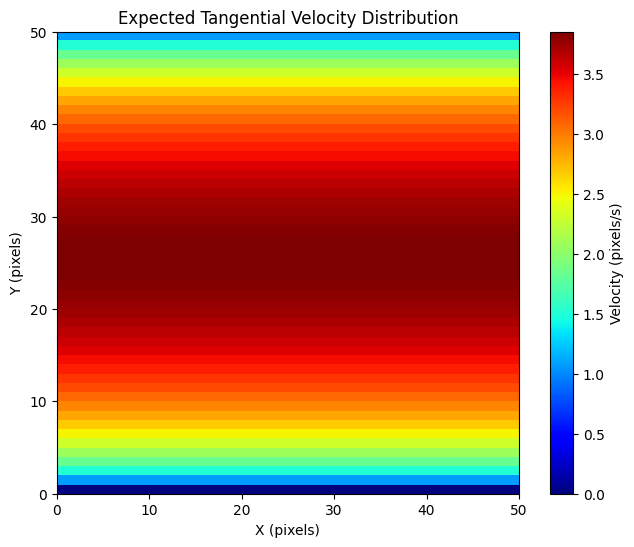

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Hardcoded ROI
x, y, w, h = 618, 220, 444, 386  # ROI coordinates

video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    raise ValueError("FPS could not be retrieved. Check the video file.")
frame_time = 1 / fps

# Process only the first 30 seconds
max_duration = 360  # seconds
max_frames = int(fps * max_duration)

# Rotation constants
rotation_period = 326  # 5 minutes 26 seconds (in seconds)
angular_velocity = 2 * np.pi / rotation_period  # Angular velocity (radians/second)

# Detect globe in the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")
gray_first = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Extract ROI from the first frame
roi_first = gray_first[y:y+h, x:x+w]

# Detect the globe using Hough Circles
circles = cv2.HoughCircles(
    roi_first,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=50,
    param1=50,
    param2=30,
    minRadius=100,
    maxRadius=250,
)

if circles is None:
    raise ValueError("No globe detected within the ROI.")
circles = np.uint16(np.around(circles))[0, 0]  # Take the first detected circle
circle_center = (circles[0], circles[1])  # (x, y) center of the circle
circle_radius = circles[2]  # Radius of the globe

# Create a circular mask for the globe
mask = np.zeros_like(roi_first, dtype=np.uint8)
cv2.circle(mask, circle_center, circle_radius, 255, -1)

# Use SIFT for feature detection within the mask (only in the first frame)
sift = cv2.SIFT_create(nfeatures=5000)
kp = sift.detect(roi_first, mask)
if len(kp) == 0:
    raise ValueError("No features detected within the globe mask.")

# Convert keypoints to numpy array of shape (N, 2), adjusting to global coords
features = np.array([kp_.pt for kp_ in kp], dtype=np.float32)
features_global = features.copy()
features_global[:, 0] += x
features_global[:, 1] += y

# Enforce maximum number of tracked features
max_features = 100  # Limit for maximum tracked features
if len(features_global) > max_features:
    features_global = features_global[np.random.choice(len(features_global), max_features, replace=False)]

# Ensure all selected features are inside the circular mask
distances = np.linalg.norm(features_global - np.array([x + circle_center[0], y + circle_center[1]]), axis=1)
features_global = features_global[distances <= circle_radius]

# Initialize tracking
all_positions = [features_global]
prev_gray = gray_first
frame_count = 0

# Precompute velocity map using the mask radius
grid_size_x, grid_size_y = 50, 50  # Grid resolution
velocity_map = np.zeros((grid_size_y, grid_size_x))  # Initialize velocity map

# Calculate tangential velocity for each grid cell
y_center = grid_size_y // 2  # Vertical center of the grid (equator)
for j in range(grid_size_y):
    for i in range(grid_size_x):
        relative_y = (j - y_center) / (grid_size_y // 2)  # Normalized latitude
        if abs(relative_y) <= 1.0:
            latitude = np.arcsin(relative_y)
            velocity_map[j, i] = angular_velocity * circle_radius * np.cos(latitude)  # Tangential velocity
        else:
            velocity_map[j, i] = 0  # Outside the circle

# Plot the velocity map
plt.figure(figsize=(8, 6))
plt.imshow(velocity_map, cmap='jet', extent=(0, grid_size_x, grid_size_y, 0), norm=Normalize())
plt.colorbar(label="Velocity (pixels/s)")
plt.title("Expected Tangential Velocity Distribution")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.gca().invert_yaxis()
plt.show()

# Normalize velocity map for color mapping
norm = Normalize(vmin=velocity_map.min(), vmax=velocity_map.max())

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > max_frames:
        # Stop after 30 seconds
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Track features using optical flow
    p0 = all_positions[-1].astype(np.float32)
    # Convert p0 to ROI coords for optical flow
    p0_roi = p0.copy()
    p0_roi[:, 0] -= x
    p0_roi[:, 1] -= y

    new_features, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray[y:y+h, x:x+w],
        gray[y:y+h, x:x+w],
        p0_roi,
        None
    )

    if new_features is None:
        # No new features tracked
        break

    valid_new_roi = new_features[status.flatten() == 1]
    valid_old_roi = p0_roi[status.flatten() == 1]

    # Convert back to global coords
    valid_new = np.zeros_like(valid_new_roi)
    valid_new[:, 0] = valid_new_roi[:, 0] + x
    valid_new[:, 1] = valid_new_roi[:, 1] + y

    # Draw the points with colors based on their velocity from the velocity map
    display_frame = frame.copy()
    for new in valid_new_roi:
        grid_x = int(new[0] / (w / grid_size_x))
        grid_y = int(new[1] / (h / grid_size_y))
        if 0 <= grid_x < grid_size_x and 0 <= grid_y < grid_size_y:
            velocity = velocity_map[grid_y, grid_x]
            color = cm.jet(norm(velocity))[:3]  # Normalize velocity to color map
            color_bgr = tuple(int(c * 255) for c in color[::-1])  # Convert to BGR
            x_new, y_new = int(new[0] + x), int(new[1] + y)
            cv2.circle(display_frame, (x_new, y_new), 3, color_bgr, -1)
            cv2.putText(display_frame, f"{velocity:.1f} px/s", (x_new + 5, y_new - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

    # Draw detected globe
    #cv2.circle(display_frame[y:y+h, x:x+w], circle_center, circle_radius, (255, 0, 0), 2)

    # Show the video with tracked points and colors
    cv2.imshow('Video with Tracked Points', display_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update for next iteration
    prev_gray = gray
    all_positions.append(valid_new)

cap.release()
cv2.destroyAllWindows()
